In [3]:
baselines = {"Task001_adhesion_clf": 0.983, "Task002_nodule_clf": 0.959, "Task003_kidney_clf": 0.842,
             "Task004_skin_case_selection_clf": 0.996, "Task005_recist_timeline_clf": 0.944,
             "Task006_pathology_tumor_origin_clf": 0.631, "Task007_nodule_diameter_presence_clf": 0.870,
             "Task008_pdac_size_presence_clf": 0.640, "Task009_pdac_diagnosis_clf": 0.767, "Task010_prostate_radiology_clf": 0.975,
             "Task011_prostate_pathology_clf": 0.861, "Task012_pathology_tissue_type_clf": 0.428, "Task013_pathology_tissue_origin_clf": 0.669, "Task014_textual_entailment_clf": 0.577, "Task015_colon_pathology_clf": 0.991, "Task016_recist_lesion_size_presence_clf": 0.903, "Task017_pdac_attributes_clf": 0.639, "Task018_osteoarthritis_clf": 0.686,
             "Task019_prostate_volume_reg": 0.981, "Task020_psa_reg": 0.974, "Task021_psad_reg": 0.955, "Task022_pdac_size_reg": 0.854, "Task023_nodule_diameter_reg": 0.818,
             "Task024_recist_lesion_size_reg": 0.783
             }

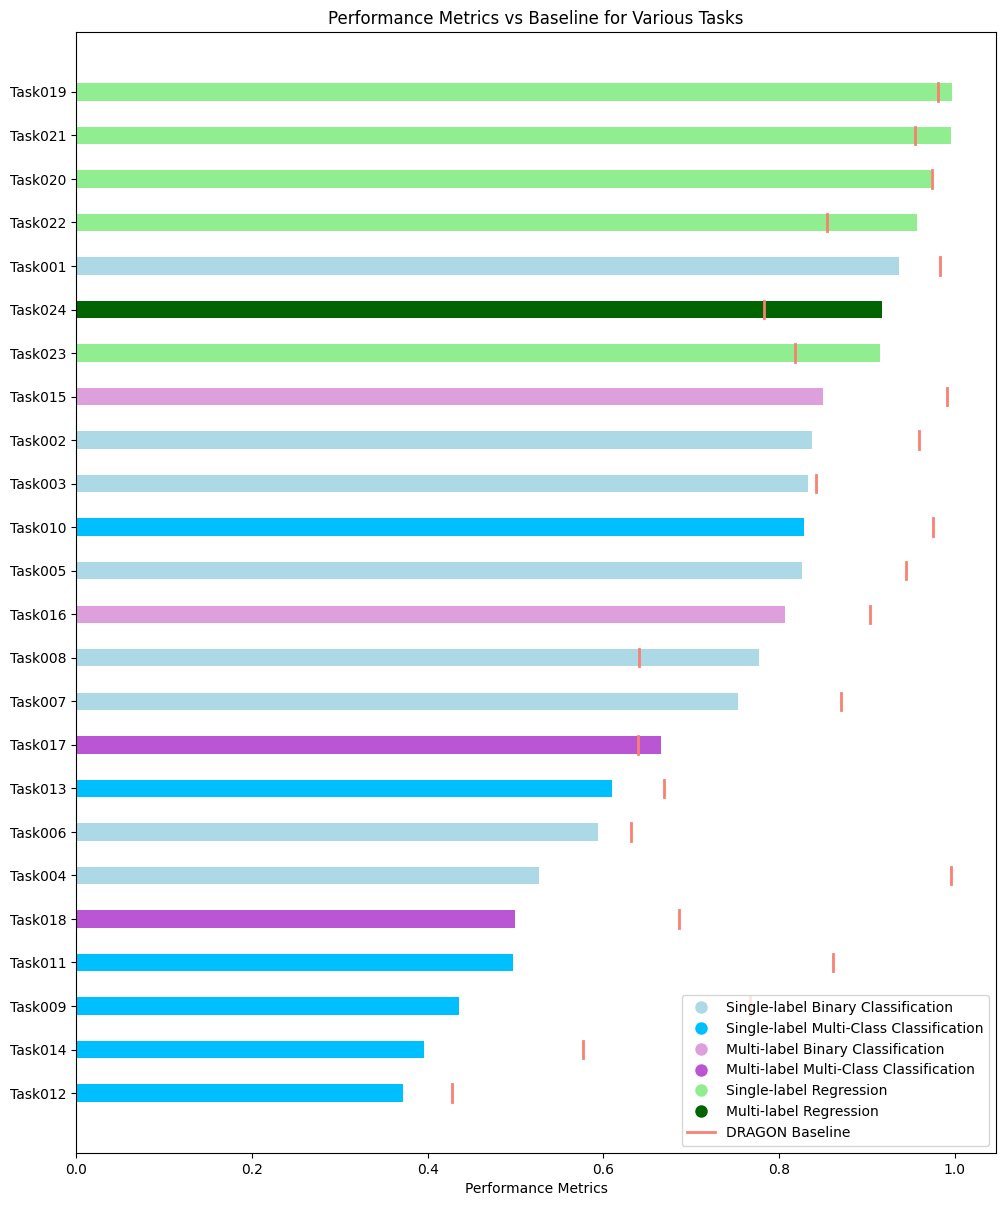

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load metrics from JSON file
metricsfile = "/data/bodyct/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/metrics.json"
with open(metricsfile, 'r') as file:
    metrics_data = json.load(file)

# Extract mean performance values from the metrics JSON
performance_data = {task: details['mean'] for task, details in metrics_data['aggregates'].items() if task != 'overall'}

# Create DataFrame from metrics and baselines
df_metrics = pd.DataFrame(list(performance_data.items()), columns=['Task', 'Performance'])
df_baselines = pd.DataFrame(list(baselines.items()), columns=['Task', 'Baseline'])
df = pd.merge(df_metrics, df_baselines, on='Task')

# Simplify task labels and categorize tasks
df['TaskID'] = df['Task'].apply(lambda x: x.split('_')[0])  # Extracts 'TaskXXX'

# Define task categories
def categorize_task(task_name):
    task_num = int(task_name.split('_')[0][4:])  # Extract numeric part
    if 1 <= task_num <= 8:
        return 'Single-label Binary Classification'
    elif 9 <= task_num <= 14:
        return 'Single-label Multi-Class Classification'
    elif 15 <= task_num <= 16:
        return 'Multi-label Binary Classification'
    elif 17 <= task_num <= 18:
        return 'Multi-label Multi-Class Classification'
    elif 19 <= task_num <= 23:
        return 'Single-label Regression'
    elif task_num == 24:
        return 'Multi-label Regression'
    else:
        return 'Other'

df['Category'] = df['Task'].apply(categorize_task)

# Sort tasks by performance in descending order
df = df.sort_values(by='Performance', ascending=False).reset_index(drop=True)

# Dynamically adjust figure height based on the number of tasks
task_count = len(df['Task'])
plt.figure(figsize=(10, 0.5 * task_count))  # Set height proportional to task count

y = range(task_count)

# Color coding for each category
colors = {
    'Single-label Binary Classification': 'lightblue',
    'Single-label Multi-Class Classification': 'deepskyblue',
    'Multi-label Binary Classification': 'plum',
    'Multi-label Multi-Class Classification': 'mediumorchid',
    'Single-label Regression': 'lightgreen',
    'Multi-label Regression': 'darkgreen'
}

# Horizontal bars for actual performance
for idx, row in df.iterrows():
    plt.barh(y=idx, width=row['Performance'], height=0.4, color=colors[row['Category']], label='_nolegend_')
    # Add a small line to indicate baseline performance
    plt.plot([row['Baseline'], row['Baseline']], [idx - 0.2, idx + 0.2], color='salmon', linewidth=2)

# Reverse the y-axis to show best performance at the top
plt.gca().invert_yaxis()

# Customize plot labels and legend
plt.yticks(ticks=y, labels=df['TaskID'])
plt.xlabel("Performance Metrics")
plt.title("Performance Metrics vs Baseline for Various Tasks")

# Custom legend for categories
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Binary Classification', markerfacecolor='lightblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Multi-Class Classification', markerfacecolor='deepskyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Binary Classification', markerfacecolor='plum', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Multi-Class Classification', markerfacecolor='mediumorchid', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Regression', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Regression', markerfacecolor='darkgreen', markersize=10),
    plt.Line2D([0], [0], color='salmon', linewidth=2, label='DRAGON Baseline')
]

plt.legend(handles=legend_patches, loc='lower right')

# Apply tight layout with minimal padding
plt.tight_layout(pad=0.5)
plt.show()


In [21]:
import json
from pathlib import Path

task_ids = df['TaskID']
output_path = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/")

failed_cases_dict = {}

for task_id in task_ids:
    num_failed_cases = 0  # Move initialization here
    total_cases = 0
    try:
        task_folders = list(output_path.glob(f"{task_id}_*"))

        for task_folder in task_folders:
            filepath = task_folder / "nlp-predictions-dataset.json"
            
            try:
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Count cases where 'status' is not 'success'
                    failed_cases = sum(1 for case in data if case['status'] != 'success')
                    print(f"Task {task_id}: {failed_cases} failed cases out of {len(data)}")
                    num_failed_cases += failed_cases
                    total_cases += len(data)
            
            except Exception as e:
                print(f"Error in {task_folder}: {e}")
                continue  # Skip to the next folder if there is an error

        failed_cases_dict[task_id] = num_failed_cases  # Save after all folders checked
        failed_cases_dict[f"{task_id}_total"] = total_cases
        percentage_failed = num_failed_cases / total_cases * 100
        failed_cases_dict[f"{task_id}_percentage"] = percentage_failed

    except Exception as e:
        print(f"Task {task_id} failed to load: {e}")
        continue  # Skip to the next task_id if the task folder fails entirely

print(failed_cases_dict)


Task Task019: 0 failed cases out of 1541
Task Task019: 0 failed cases out of 1541
Task Task019: 0 failed cases out of 1541
Task Task019: 0 failed cases out of 1541
Task Task019: 0 failed cases out of 1541
Task Task021: 0 failed cases out of 1410
Task Task021: 1 failed cases out of 1410
Task Task021: 1 failed cases out of 1410
Task Task021: 0 failed cases out of 1410
Task Task021: 0 failed cases out of 1410
Task Task020: 3 failed cases out of 1428
Task Task020: 3 failed cases out of 1428
Task Task020: 4 failed cases out of 1428
Task Task020: 5 failed cases out of 1428
Task Task020: 2 failed cases out of 1428
Task Task022: 1 failed cases out of 103
Task Task022: 0 failed cases out of 103
Task Task022: 0 failed cases out of 103
Task Task022: 1 failed cases out of 103
Task Task022: 0 failed cases out of 103
Task Task001: 0 failed cases out of 119
Task Task001: 0 failed cases out of 119
Task Task001: 0 failed cases out of 119
Task Task001: 0 failed cases out of 119
Task Task001: 0 failed ca

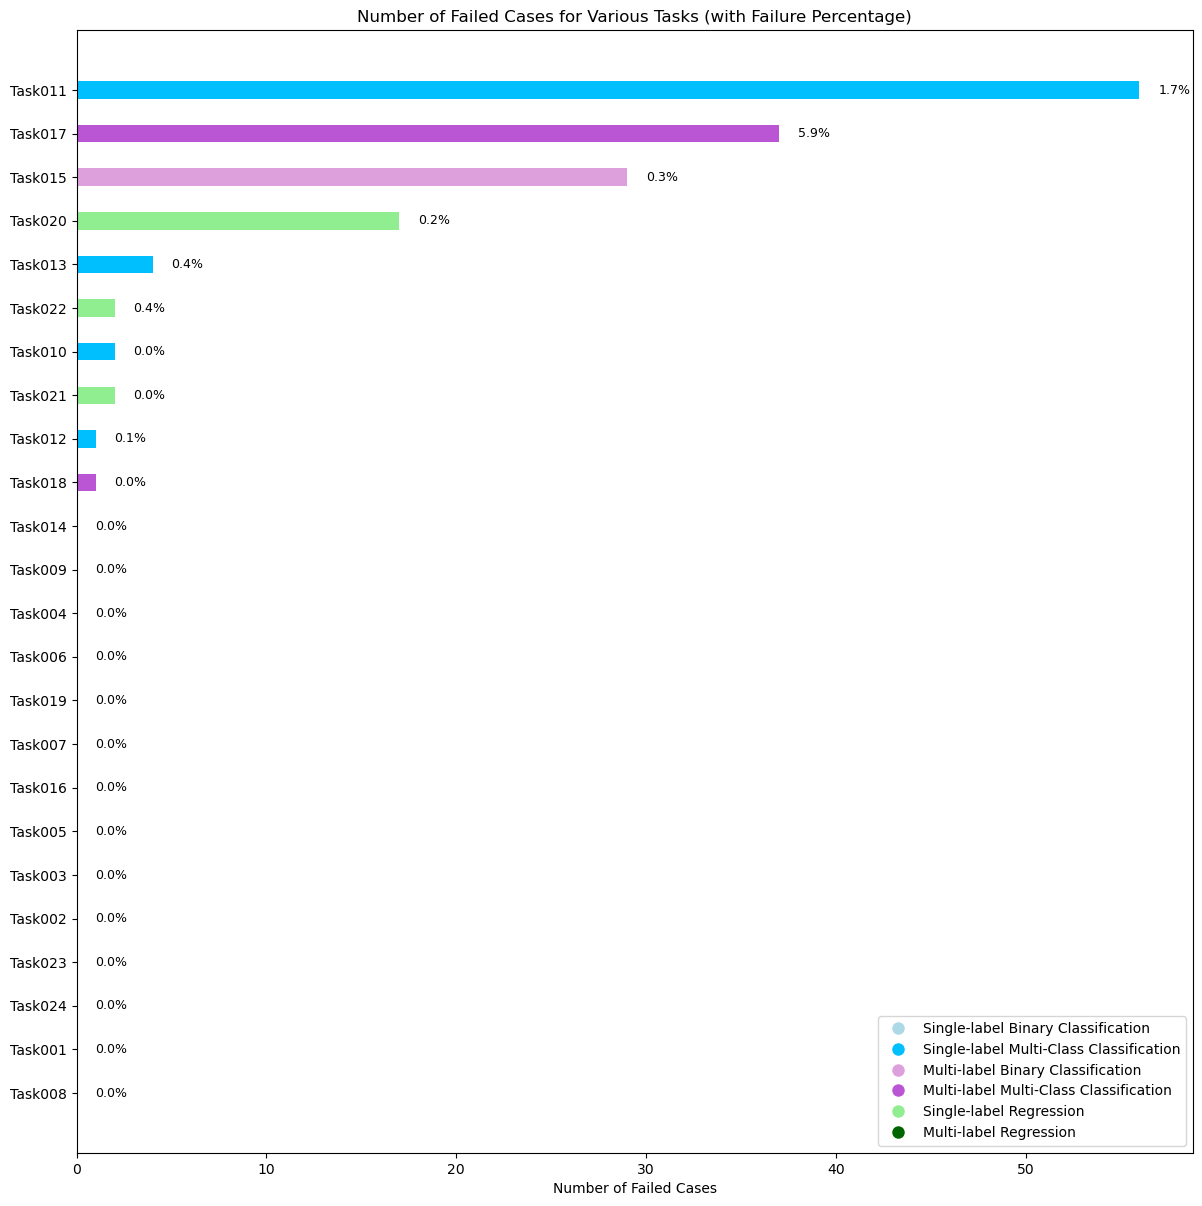

In [23]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Sort the DataFrame by the number of failed cases in descending order
df_sorted = df.copy()  # Make a copy to avoid changing the original DataFrame
df_sorted['FailedCases'] = df_sorted['TaskID'].map(lambda task: failed_cases_dict.get(task, 0))
df_sorted['TotalCases'] = df_sorted['TaskID'].map(lambda task: failed_cases_dict.get(f"{task}_total", 0))
df_sorted['FailedPercentage'] = df_sorted['TaskID'].map(lambda task: failed_cases_dict.get(f"{task}_percentage", 0.0))
df_sorted = df_sorted.sort_values(by='FailedCases', ascending=False).reset_index(drop=True)

# Dynamically adjust figure height based on the number of tasks
plt.figure(figsize=(12, 0.5 * len(df_sorted)))  # Adjust height based on the sorted DataFrame

y = range(len(df_sorted))

# Define color coding for each task category
colors = {
    'Single-label Binary Classification': 'lightblue',
    'Single-label Multi-Class Classification': 'deepskyblue',
    'Multi-label Binary Classification': 'plum',
    'Multi-label Multi-Class Classification': 'mediumorchid',
    'Single-label Regression': 'lightgreen',
    'Multi-label Regression': 'darkgreen'
}

# Horizontal bars for failed cases
for idx, row in df_sorted.iterrows():
    plt.barh(y=idx, width=row['FailedCases'], height=0.4, color=colors[row['Category']], label='_nolegend_')
    # Annotate with the percentage of failed cases
    plt.text(row['FailedCases'] + 1, idx, f"{row['FailedPercentage']:.1f}%", va='center', color='black', fontsize=9)

# Reverse the y-axis to show the highest failure rates at the top
plt.gca().invert_yaxis()

# Customize plot labels and legend
plt.yticks(ticks=y, labels=df_sorted['TaskID'])
plt.xlabel("Number of Failed Cases")
plt.title("Number of Failed Cases for Various Tasks (with Failure Percentage)")

# Custom legend for categories
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Binary Classification', markerfacecolor='lightblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Multi-Class Classification', markerfacecolor='deepskyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Binary Classification', markerfacecolor='plum', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Multi-Class Classification', markerfacecolor='mediumorchid', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Single-label Regression', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Multi-label Regression', markerfacecolor='darkgreen', markersize=10)
]

plt.legend(handles=legend_patches, loc='lower right')

# Apply tight layout with minimal padding
plt.tight_layout(pad=0.5)
plt.show()


In [16]:
import json
from pathlib import Path

task_ids = df['TaskID']
output_path = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/")

retries_dict = {}

for task_id in task_ids:
    num_retries = 0  # Move initialization here
    total_cases = 0
    try:
        task_folders = list(output_path.glob(f"{task_id}_*"))

        for task_folder in task_folders:
            filepath = task_folder / "nlp-predictions-dataset.json"
            
            try:
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Count cases where 'status' is not 'success'
                    retries = sum(n for case in data if (n := case.get('retries', 0)) > 0)
                    average_retries = sum(n for case in data) / len(data) if len(data) > 0 else 0
                    # print(f"Task {task_id}: {retries} retries in {len(data)} data points")
                    print(f"Task {task_id}: {retries} retries in {len(data)} data points (avg. {average_retries:.2f} retries)")
                    num_failed_cases += failed_cases
                    total_cases += len(data)
            
            except Exception as e:
                print(f"Error in {task_folder}: {e}")
                continue  # Skip to the next folder if there is an error

        failed_cases_dict[task_id] = num_failed_cases  # Save after all folders checked
        failed_cases_dict[f"{task_id}_total"] = total_cases
        percentage_failed = num_failed_cases / total_cases * 100
        failed_cases_dict[f"{task_id}_percentage"] = percentage_failed

    except Exception as e:
        print(f"Task {task_id} failed to load: {e}")
        continue  # Skip to the next task_id if the task folder fails entirely

print(failed_cases_dict)


Task Task019: 0 retries in 1541 data points (avg. 0.00 retries)
Task Task019: 0 retries in 1541 data points (avg. 0.00 retries)
Task Task019: 0 retries in 1541 data points (avg. 0.00 retries)
Task Task019: 0 retries in 1541 data points (avg. 0.00 retries)
Task Task019: 0 retries in 1541 data points (avg. 0.00 retries)
Task Task021: 0 retries in 1410 data points (avg. 0.00 retries)
Task Task021: 2821 retries in 1410 data points (avg. 2.00 retries)
Task Task021: 2821 retries in 1410 data points (avg. 2.00 retries)
Task Task021: 0 retries in 1410 data points (avg. 0.00 retries)
Task Task021: 0 retries in 1410 data points (avg. 0.00 retries)
Task Task020: 2859 retries in 1428 data points (avg. 2.00 retries)
Task Task020: 2859 retries in 1428 data points (avg. 2.00 retries)
Task Task020: 2860 retries in 1428 data points (avg. 2.00 retries)
Task Task020: 2861 retries in 1428 data points (avg. 2.00 retries)
Task Task020: 2858 retries in 1428 data points (avg. 2.00 retries)
Task Task022: 207 r

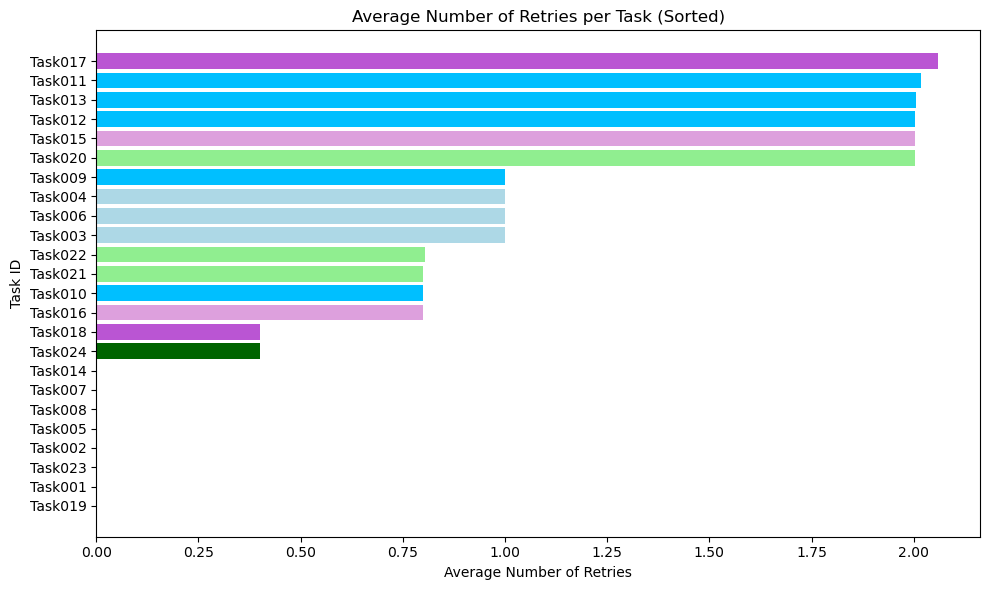

In [25]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

# Assuming df['TaskID'] and df['Category'] are already defined
task_ids = df['TaskID']
output_path = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/")

average_retries_dict = {}

for task_id in task_ids:
    try:
        task_folders = list(output_path.glob(f"{task_id}_*"))
        
        num_retries = 0  # Initialize retries for each task
        total_cases = 0  # Initialize total cases for each task

        for task_folder in task_folders:
            filepath = task_folder / "nlp-predictions-dataset.json"
            
            try:
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Sum retries across cases and count total cases
                    retries = sum(case.get('retries', 0) for case in data)
                    num_retries += retries
                    total_cases += len(data)
            
            except Exception as e:
                print(f"Error in {task_folder}: {e}")
                continue  # Skip to the next folder if there is an error

        # Calculate and store average retries per task
        average_retries = num_retries / total_cases if total_cases > 0 else 0
        average_retries_dict[task_id] = average_retries

    except Exception as e:
        print(f"Task {task_id} failed to load: {e}")
        continue  # Skip to the next task_id if the task folder fails entirely

# Sort the dictionary by average retries
sorted_average_retries = dict(sorted(average_retries_dict.items(), key=lambda item: item[1]))

# Create a color mapping based on the same color scheme
colors = {
    'Single-label Binary Classification': 'lightblue',
    'Single-label Multi-Class Classification': 'deepskyblue',
    'Multi-label Binary Classification': 'plum',
    'Multi-label Multi-Class Classification': 'mediumorchid',
    'Single-label Regression': 'lightgreen',
    'Multi-label Regression': 'darkgreen'
}

# Map colors to each task based on its category
task_colors = [colors[df.loc[df['TaskID'] == task_id, 'Category'].values[0]] for task_id in sorted_average_retries.keys()]

# Plot the sorted average retries per task as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_average_retries.keys()), list(sorted_average_retries.values()), color=task_colors)
plt.xlabel("Average Number of Retries")
plt.ylabel("Task ID")
plt.title("Average Number of Retries per Task (Sorted)")

# Rotate y-tick labels for better readability
plt.yticks(rotation=0)  # Ensure task labels are horizontal on the left

# Apply tight layout for minimal padding
plt.tight_layout()
plt.show()


# Bugfix task13

In [1]:
from pathlib import Path
import json

predictionspath = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/Task013_pathology_tissue_origin_clf-fold0/nlp-predictions-dataset.json")
groundtruthpath = Path("B:/experiments/luc_t10162/DRAGON/debug-test-set/Task013_pathology_tissue_origin_clf.json")

predictions = json.loads(predictionspath.read_text())
groundtruth = json.loads(groundtruthpath.read_text())

predictions = {case['uid']: case['single_label_multi_class_classification'] for case in predictions}
groundtruth = {case['uid']: case['single_label_multi_class_classification_target'] for case in groundtruth}

# Find cases where the prediction does not match the ground truth
mismatches = {uid: (predictions[uid], groundtruth[uid]) for uid in predictions if predictions[uid] != groundtruth[uid]}
# Count the number of mismatches
mismatch_count = len(mismatches)
print(f"Number of mismatches: {mismatch_count} out of {len(predictions)} cases")

# For each label, print how many times it was predicted as each class
labels = set(predictions.values())
for label in labels:
    print(f"Label: {label} ({sum(1 for uid in predictions if predictions[uid] == label)} cases)")
    for class_ in set(predictions.values()):
        count = sum(1 for uid in predictions if predictions[uid] == label and groundtruth[uid] == class_)
        print(f"  {class_}: {count}")
    print()

Number of mismatches: 74 out of 215 cases
Label: pleural fluid (2 cases)
  pleural fluid: 0
  lymph node: 0
  liver: 0
  bronchus: 0
  bone: 0
  lung: 2
  other: 0
  brain: 0

Label: lymph node (7 cases)
  pleural fluid: 0
  lymph node: 6
  liver: 0
  bronchus: 0
  bone: 0
  lung: 1
  other: 0
  brain: 0

Label: liver (1 cases)
  pleural fluid: 0
  lymph node: 0
  liver: 0
  bronchus: 0
  bone: 0
  lung: 1
  other: 0
  brain: 0

Label: bronchus (4 cases)
  pleural fluid: 0
  lymph node: 0
  liver: 0
  bronchus: 0
  bone: 0
  lung: 3
  other: 1
  brain: 0

Label: bone (4 cases)
  pleural fluid: 0
  lymph node: 0
  liver: 0
  bronchus: 0
  bone: 3
  lung: 0
  other: 1
  brain: 0

Label: lung (164 cases)
  pleural fluid: 0
  lymph node: 7
  liver: 3
  bronchus: 14
  bone: 2
  lung: 124
  other: 12
  brain: 2

Label: other (25 cases)
  pleural fluid: 0
  lymph node: 2
  liver: 0
  bronchus: 0
  bone: 0
  lung: 21
  other: 2
  brain: 0

Label: brain (8 cases)
  pleural fluid: 0
  lymph node

In [2]:
# Same for task009
predictionspath = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/Task009_pdac_diagnosis_clf-fold0/nlp-predictions-dataset.json")
groundtruthpath = Path("B:/experiments/luc_t10162/DRAGON/debug-test-set/Task009_pdac_diagnosis_clf.json")

predictions = json.loads(predictionspath.read_text())
groundtruth = json.loads(groundtruthpath.read_text())

predictions = {case['uid']: case['single_label_multi_class_classification'] for case in predictions}
groundtruth = {case['uid']: case['single_label_multi_class_classification_target'] for case in groundtruth}

# Find cases where the prediction does not match the ground truth
mismatches = {uid: (predictions[uid], groundtruth[uid]) for uid in predictions if predictions[uid] != groundtruth[uid]}
# Count the number of mismatches
mismatch_count = len(mismatches)
print(f"Number of mismatches: {mismatch_count} out of {len(predictions)} cases")

# For each label, print how many times it was predicted as each class
labels = set(predictions.values())
for label in labels:
    print(f"Label: {label} ({sum(1 for uid in predictions if predictions[uid] == label)} cases)")
    for class_ in set(predictions.values()):
        count = sum(1 for uid in predictions if predictions[uid] == label and groundtruth[uid] == class_)
        print(f"  {class_}: {count}")
    print()

Number of mismatches: 161 out of 412 cases
Label: Normal pancreas (147 cases)
  Normal pancreas: 129
  Other pancreatic disease: 15
  PDAC: 3

Label: Other pancreatic disease (72 cases)
  Normal pancreas: 50
  Other pancreatic disease: 16
  PDAC: 6

Label: PDAC (193 cases)
  Normal pancreas: 42
  Other pancreatic disease: 45
  PDAC: 106



In [6]:
# Same for task011
predictionspath = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/Task011_prostate_pathology_clf-fold0/nlp-predictions-dataset.json")
groundtruthpath = Path("B:/experiments/luc_t10162/DRAGON/debug-test-set/Task011_prostate_pathology_clf.json")

predictions = json.loads(predictionspath.read_text())
groundtruth = json.loads(groundtruthpath.read_text())

predictions = {case['uid']: case['single_label_multi_class_classification'] for case in predictions}
groundtruth = {case['uid']: case['single_label_multi_class_classification_target'] for case in groundtruth}

# Make sure that the predictions and ground truth are all integers
predictions = {uid: float(label) for uid, label in predictions.items()}
groundtruth = {uid: float(label) for uid, label in groundtruth.items()}

# Find cases where the prediction does not match the ground truth
mismatches = {uid: (predictions[uid], groundtruth[uid]) for uid in predictions if predictions[uid] != groundtruth[uid]}
# Count the number of mismatches
mismatch_count = len(mismatches)
print(f"Number of mismatches: {mismatch_count} out of {len(predictions)} cases")

# For each label, print how many times it was predicted as each class
labels = set(predictions.values())
for label in labels:
    print(f"Label: {label} ({sum(1 for uid in predictions if predictions[uid] == label)} cases)")
    for class_ in set(predictions.values()):
        count = sum(1 for uid in predictions if predictions[uid] == label and groundtruth[uid] == class_)
        print(f"  {class_}: {count}")
    print()

Number of mismatches: 254 out of 664 cases
Label: 0.0 (279 cases)
  0.0: 271
  1.0: 7
  2.0: 1
  3.0: 0

Label: 1.0 (138 cases)
  0.0: 23
  1.0: 110
  2.0: 4
  3.0: 1

Label: 2.0 (186 cases)
  0.0: 15
  1.0: 141
  2.0: 27
  3.0: 3

Label: 3.0 (61 cases)
  0.0: 5
  1.0: 47
  2.0: 7
  3.0: 2



In [7]:
# Same for task012
predictionspath = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/Task012_pathology_tissue_type_clf-fold0/nlp-predictions-dataset.json")
groundtruthpath = Path("B:/experiments/luc_t10162/DRAGON/debug-test-set/Task012_pathology_tissue_type_clf.json")

predictions = json.loads(predictionspath.read_text())
groundtruth = json.loads(groundtruthpath.read_text())

predictions = {case['uid']: case['single_label_multi_class_classification'] for case in predictions}
groundtruth = {case['uid']: case['single_label_multi_class_classification_target'] for case in groundtruth}

# # Make sure that the predictions and ground truth are all integers
# predictions = {uid: float(label) for uid, label in predictions.items()}
# groundtruth = {uid: float(label) for uid, label in groundtruth.items()}

# Find cases where the prediction does not match the ground truth
mismatches = {uid: (predictions[uid], groundtruth[uid]) for uid in predictions if predictions[uid] != groundtruth[uid]}
# Count the number of mismatches
mismatch_count = len(mismatches)
print(f"Number of mismatches: {mismatch_count} out of {len(predictions)} cases")

# For each label, print how many times it was predicted as each class
labels = set(predictions.values())
for label in labels:
    print(f"Label: {label} ({sum(1 for uid in predictions if predictions[uid] == label)} cases)")
    for class_ in set(predictions.values()):
        count = sum(1 for uid in predictions if predictions[uid] == label and groundtruth[uid] == class_)
        print(f"  {class_}: {count}")
    print

Number of mismatches: 69 out of 212 cases
Label: Excision (8 cases)
  Excision: 2
  Biopsy: 4
  Resection: 2
Label: Biopsy (122 cases)
  Excision: 9
  Biopsy: 95
  Resection: 18
Label: Resection (82 cases)
  Excision: 8
  Biopsy: 28
  Resection: 46


In [8]:
# Same for task014
predictionspath = Path("B:/experiments/luc_t10162/GitHub/LLM_data_extractor/output/mistral-nemo/0_examples/Task014_textual_entailment_clf-fold0/nlp-predictions-dataset.json")
groundtruthpath = Path("B:/experiments/luc_t10162/DRAGON/debug-test-set/Task014_textual_entailment_clf.json")

predictions = json.loads(predictionspath.read_text())
groundtruth = json.loads(groundtruthpath.read_text())

predictions = {case['uid']: case['single_label_multi_class_classification'] for case in predictions}
groundtruth = {case['uid']: case['single_label_multi_class_classification_target'] for case in groundtruth}

# Find cases where the prediction does not match the ground truth
mismatches = {uid: (predictions[uid], groundtruth[uid]) for uid in predictions if predictions[uid] != groundtruth[uid]}
# Count the number of mismatches
mismatch_count = len(mismatches)
print(f"Number of mismatches: {mismatch_count} out of {len(predictions)} cases")

# For each label, print how many times it was predicted as each class
labels = set(predictions.values())
for label in labels:
    print(f"Label: {label} ({sum(1 for uid in predictions if predictions[uid] == label)} cases)")
    for class_ in set(predictions.values()):
        count = sum(1 for uid in predictions if predictions[uid] == label and groundtruth[uid] == class_)
        print(f"  {class_}: {count}")
    print()

Number of mismatches: 1632 out of 3788 cases
Label: neutral (300 cases)
  neutral: 156
  entailment: 29
  contradiction: 115

Label: entailment (2494 cases)
  neutral: 1059
  entailment: 1138
  contradiction: 297

Label: contradiction (994 cases)
  neutral: 73
  entailment: 59
  contradiction: 862



In [8]:
import json
from pathlib import Path

task004examplespath = Path("/data/bodyct/experiments/luc_t10162/GitHub/LLM_data_extractor/examples/Task004_skin_case_selection_clf_examples.json")

task004examples = json.loads(task004examplespath.read_text())

for example in task004examples:
    if example['label'] == 'False':
        example['reasoning'] = 'The report does not meet any exclusion criteria, therefore the final label is False.'
    elif example['label'] == 'True':
        example['reasoning'] = 'The report meets at least one exclusion criterion, therefore the final label is True.'
    
task004examplespath.write_text(json.dumps(task004examples, indent=4))

346374